# Porter Delivery Time Estimation!

# Contents:
* [Abstract](#1)
* [Libraries](#2)
* [Data Analysis](#3)
* [Exploratory Data Analysis](#4)
* [Data Preprocessing](#5)
* [Model Training](#6)

<a id=''></a>
# ABSTRACT
Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's 40 billion dollars intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.

Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.
* In this report i did the exploratory data analysis to observe on what factors does the delivery time varies and did used XGB Regressor to predict the same.

In [44]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.preprocessing import 

<a id='2'></a>
# Data Analysis

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df=pd.read_csv(r"C:\Users\dell\Downloads\archive (21)\dataset.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [5]:

df.head(3)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0


# feature description
* market_id: integer if for the market where the restaurant lies
* create_at: the timestamp at which order was placed
* actual_delivery_time: the timestamp when the order was placed
* store_primary_category: category for the restaurant
* order_protocaol: integer code value for order protocol(how the order was placed i.e., through porter,call to restaurnat, pre booked,third party etc
* total_items_subtotal: final price of the order
* num_distinct_items: the number of distinct items in the order
* actual_delivery_time: the timestamp when the order was deliverey
* min_item_price: price of the cheapest item in the order
* max_item_price: price of the costliest item in the order
* total_onshift_partners: number of delivery partners on duty at the time order was placed
* total_busy_partners: number of delivery partners attending to other tasks
* total_outstanding_orders: total number of orders to be fulfilled at the moment

**separating year,month and day from created_at feature to get better insights from further analysis that if there is any correlation of the delivery time with the month or if the delivery partners are more busy in certain month.**

In [6]:
#year,month and day for 'created_at'
df['year']=df['created_at'].str.split('-',expand=True)[0].astype(str).astype(int)
df['month']=df['created_at'].str.split('-',expand=True)[1].astype(str).astype(int)
df['day']=df['created_at'].str.split('-',expand=True)[2]
df['day']=df['day'].str.split(' ',expand=True)[0].astype(str).astype(int)

**We need to convert the 'created_at' and 'actual_delivery_time' feature in proper format to get delivery_time i.e., the amount of time after order being placed the delivery is done.**

In [7]:
#converting created_at and actual_delivery_time into date_time format
df['created_at']=pd.to_datetime(df['created_at'])
df['actual_delivery_time']=pd.to_datetime(df['actual_delivery_time'])

In [8]:
#creating a new feature'time_taken(mins)' to store the time taken for delivery in minutes
a=[None for _ in range(len(df))]
for i in range(len(df)):
    a[i]=pd.Timedelta(df['actual_delivery_time'].iloc[i]-df['created_at'].iloc[i]).seconds/60
df['time_taken(mins)']=a

In [9]:
#dropping created_at and actual_deivery_time because more or less we have dealt with both of them
df.drop(['created_at','actual_delivery_time'],axis=1,inplace=True)

In [10]:
df_=df.copy()    #for exploration

<a id='3'></a>
# Exploratory Data Analysis

In [11]:
# percentage of missing values in each category
dict_={}
for feature in df_.columns:
    dict_[feature]=((df_[feature].isnull().sum())/len(df_))*100
pd.DataFrame(dict_,index=['%age of missing value']).transpose()

,%age of missing value
market_id,0.499929
store_id,0.000000
store_primary_category,2.411006
order_protocol,0.503981
total_items,0.000000
subtotal,0.000000
num_distinct_items,0.000000
min_item_price,0.000000
max_item_price,0.000000
total_onshift_partners,8.236927


In [12]:
#unique values in each column
dict_={}
for feature in df_.columns:
    dict_[feature]=((df_[feature].value_counts().shape[0]))
pd.DataFrame(dict_,index=['unique_counts']).transpose()

,unique_counts
market_id,6
store_id,6743
store_primary_category,74
order_protocol,7
total_items,57
subtotal,8368
num_distinct_items,20
min_item_price,2312
max_item_price,2652
total_onshift_partners,172


In [13]:
#splitting features into categorical and numerical
categorical_feature=['market_id','store_id','store_primary_category','order_protocol','year','month']
numerical_feature=['total_items','subtotal','num_distinct_items','min_item_price','max_item_price','total_onshift_partners','total_busy_partners','total_outstanding_orders','day','time_taken(mins)']

<AxesSubplot:xlabel='market_id'>

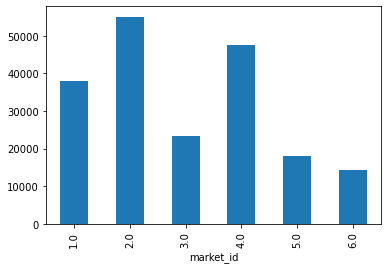

In [14]:
# total number of order from each market
df_.groupby('market_id')['store_id'].count().plot.bar()


**Most of the orders are from the stores in Market corresponding to market_id=2 and stores from market corresponding to market_id=6 has the lowest number of orders**

<AxesSubplot:xlabel='year', ylabel='count'>

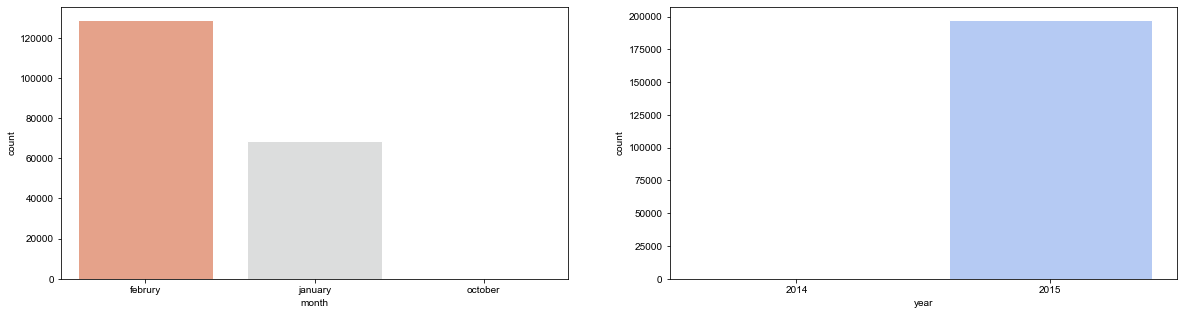

In [15]:
#Analysing what was the frequency of orders in each month and in year 2014 and 2015
df_['month']=df_['month'].map({1:'january',2:'februry',10:'october'})
fig=plt.figure(figsize=(20,5))
ax=[None for _ in range(2)]
ax[0]=plt.subplot2grid((1,2),(0,0))
ax[1]=plt.subplot2grid((1,2),(0,1))
sns.set_style('darkgrid')
sns.countplot(x='month',data=df_,palette='coolwarm_r',ax=ax[0])
sns.countplot(x='year',data=df_,palette='coolwarm_r',ax=ax[1])

**In the dataset the data is essentially for 2015 there is like one or two data from 2014 and in 2015 that too mostly from jan and feb there is again like one or two data from october**

<AxesSubplot:xlabel='order_protocol', ylabel='count'>

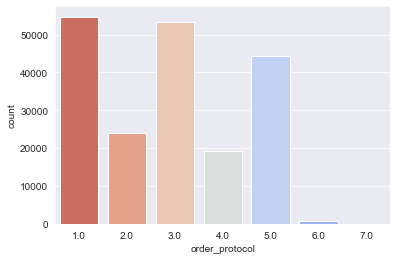

In [16]:
#ways in which different orders are placed(i.e., order protocol with most number of orders)
sns.countplot(x='order_protocol',data=df_,palette='coolwarm_r')

<AxesSubplot:>

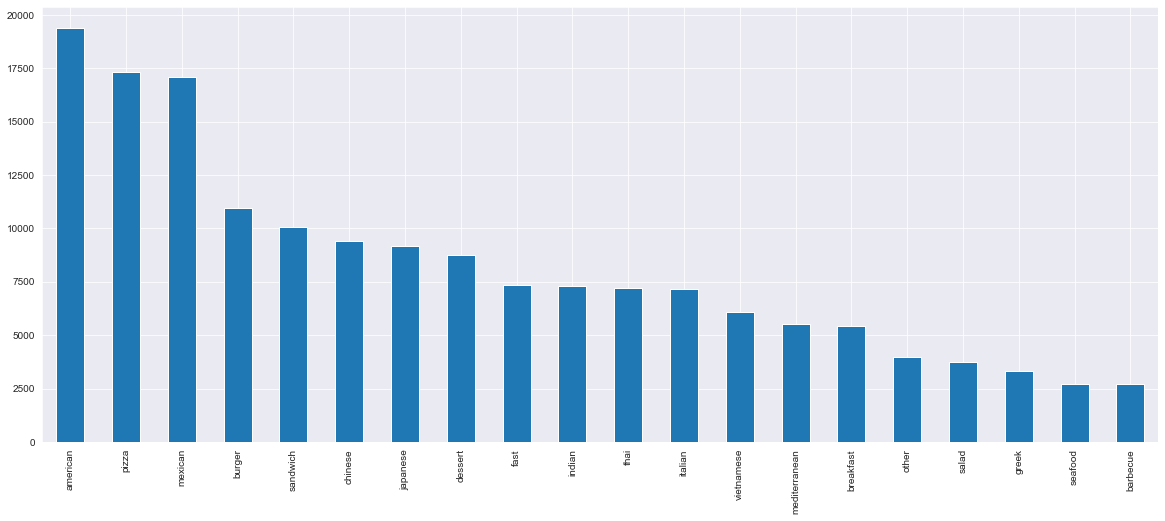

In [17]:
#top 20 i.e., most ordered category
fig=plt.figure(figsize=(20,8))
df_['store_primary_category'].value_counts().sort_values(ascending=False)[:20].plot.bar()


**'From the plot it is pretty much evident that the most of the restaurants primary category are 'american','pizza' and 'mexican' while 'salad' and all other categories are very less ordered or in ask.**

**Box-plots for observing outliers if there is any**

<AxesSubplot:xlabel='max_item_price'>

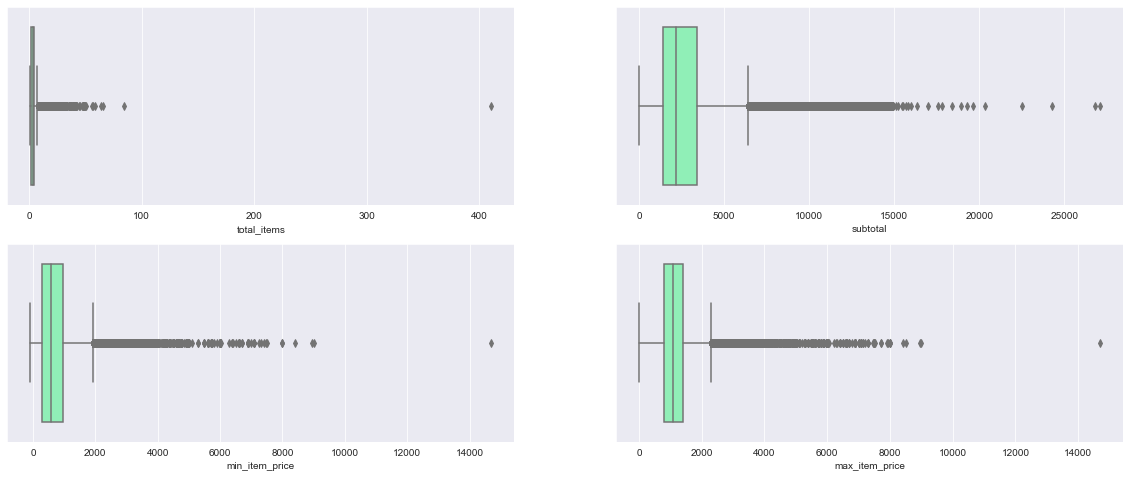

In [18]:
#Analysis of the numerical features 
fig=plt.figure(figsize=(20,8))
ax=[None for _ in range(4)]
ax[0]=plt.subplot2grid((2,2),(0,0))
ax[1]=plt.subplot2grid((2,2),(0,1))
ax[2]=plt.subplot2grid((2,2),(1,0))
ax[3]=plt.subplot2grid((2,2),(1,1))
sns.boxplot(x='total_items',data=df_,palette='rainbow',ax=ax[0])
sns.boxplot(x='subtotal',data=df_,palette='rainbow',ax=ax[1])
sns.boxplot(x='min_item_price',data=df_,palette='rainbow',ax=ax[2])
sns.boxplot(x='max_item_price',data=df_,palette='rainbow',ax=ax[3])

<AxesSubplot:xlabel='total_onshift_partners'>

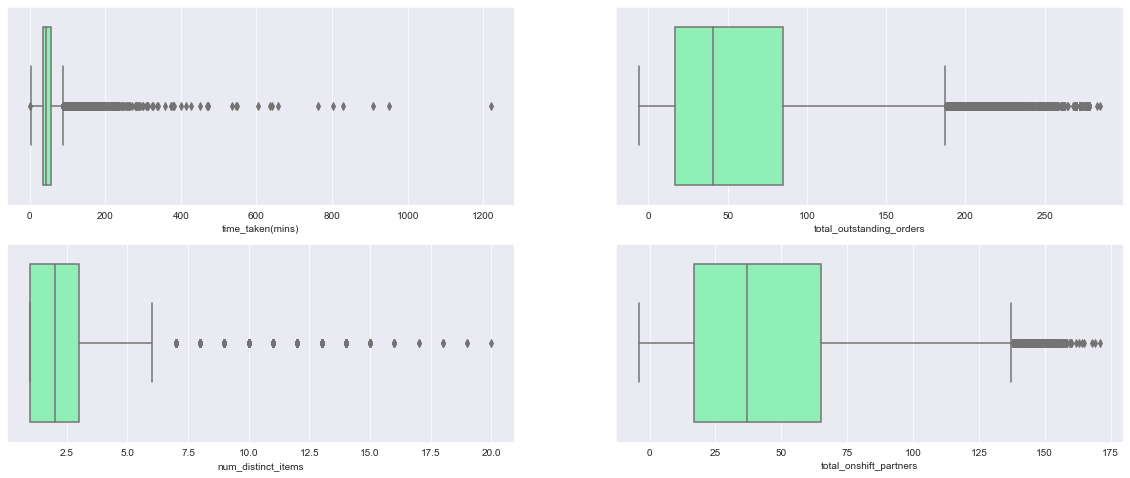

In [19]:
fig=plt.figure(figsize=(20,8))
ax=[None for _ in range(4)]
ax[0]=plt.subplot2grid((2,2),(0,0))
ax[1]=plt.subplot2grid((2,2),(0,1))
ax[2]=plt.subplot2grid((2,2),(1,0))
ax[3]=plt.subplot2grid((2,2),(1,1))
sns.boxplot(x='time_taken(mins)',data=df_,palette='rainbow',ax=ax[0])
sns.boxplot(x='total_outstanding_orders',data=df_,palette='rainbow',ax=ax[1])
sns.boxplot(x='num_distinct_items',data=df_,palette='rainbow',ax=ax[2])
sns.boxplot(x='total_onshift_partners',data=df_,palette='rainbow',ax=ax[3])

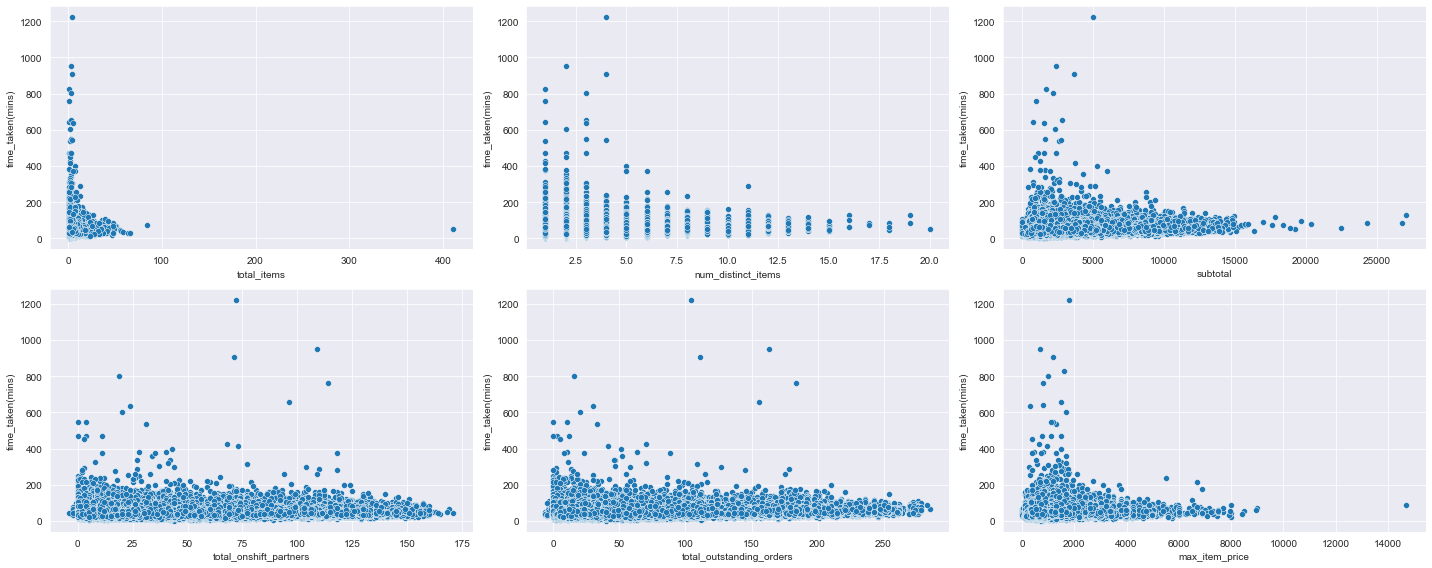

In [20]:
#bivariate analysis: to see how the other features are correlated with delivery time 'time_taken(mins)'
fig=plt.figure(figsize=(20,8))
ax=[None for _ in range(6)]
ax[0]=plt.subplot2grid((2,3),(0,0))
ax[1]=plt.subplot2grid((2,3),(0,1))
ax[2]=plt.subplot2grid((2,3),(0,2))
ax[3]=plt.subplot2grid((2,3),(1,0))
ax[4]=plt.subplot2grid((2,3),(1,1))
ax[5]=plt.subplot2grid((2,3),(1,2))
sns.scatterplot(x='total_items',y='time_taken(mins)',data=df_,ax=ax[0])
sns.scatterplot(x='num_distinct_items',y='time_taken(mins)',data=df_,ax=ax[1])
sns.scatterplot(x='subtotal',y='time_taken(mins)',data=df_,ax=ax[2])
sns.scatterplot(x='total_onshift_partners',y='time_taken(mins)',data=df_,ax=ax[3])
sns.scatterplot(x='total_outstanding_orders',y='time_taken(mins)',data=df_,ax=ax[4])
sns.scatterplot(x='max_item_price',y='time_taken(mins)',data=df_,ax=ax[5])
plt.tight_layout()

<AxesSubplot:xlabel='year', ylabel='time_taken(mins)'>

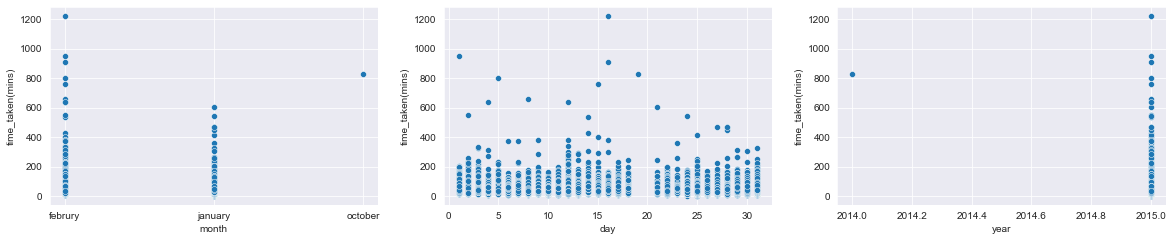

In [21]:
fig=plt.figure(figsize=(20,8))
ax=[None for _ in range(3)]
ax[0]=plt.subplot2grid((2,3),(0,0))
ax[1]=plt.subplot2grid((2,3),(0,1))
ax[2]=plt.subplot2grid((2,3),(0,2))
sns.scatterplot(x='month',y='time_taken(mins)',data=df_,ax=ax[0])
sns.scatterplot(x='day',y='time_taken(mins)',data=df_,ax=ax[1])
sns.scatterplot(x='year',y='time_taken(mins)',data=df_,ax=ax[2])

<AxesSubplot:>

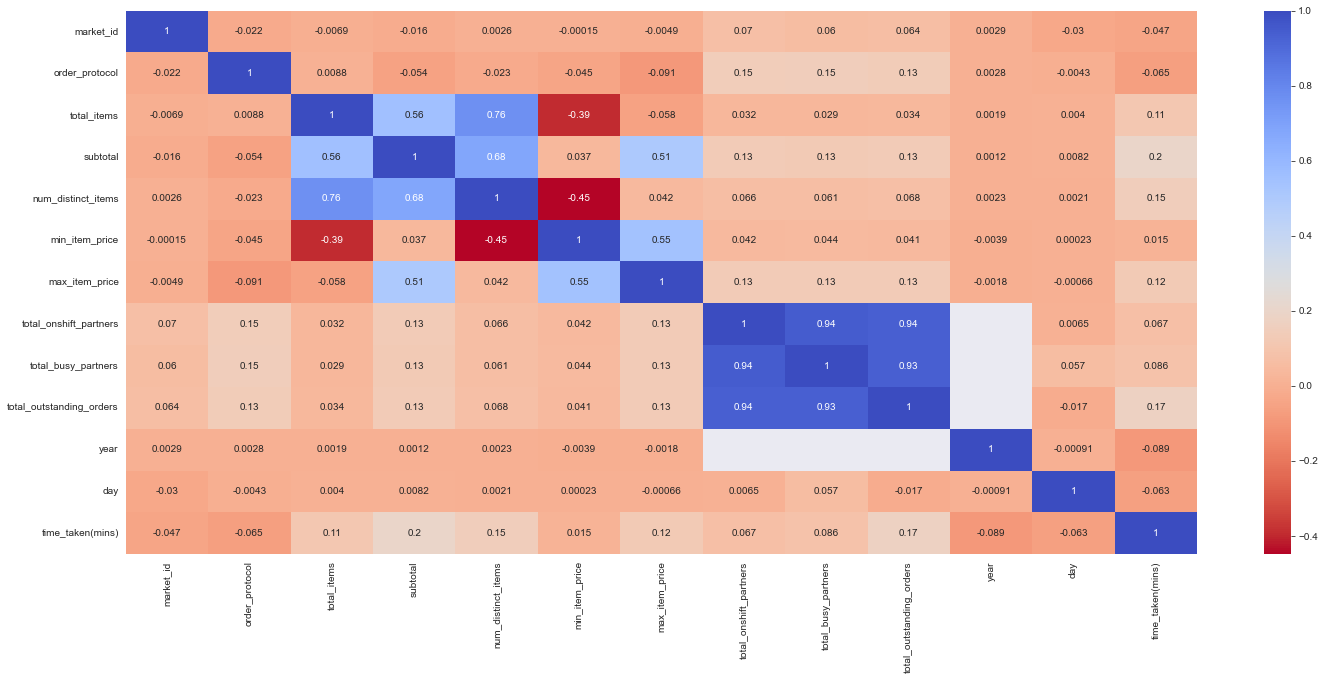

In [22]:
#correlation heatmap
plt.figure(figsize=(24,10))
corr=df_.corr()
sns.heatmap(corr,cmap='coolwarm_r',annot=True,annot_kws={'size':10})

In [23]:
df_.corr()['time_taken(mins)'].abs().sort_values(ascending=False)

time_taken(mins)            1.000000
subtotal                    0.201585
total_outstanding_orders    0.171900
num_distinct_items          0.145788
max_item_price              0.124717
total_items                 0.109556
year                        0.089187
total_busy_partners         0.085990
total_onshift_partners      0.066892
order_protocol              0.065187
day                         0.063006
market_id                   0.046592
min_item_price              0.014980
Name: time_taken(mins), dtype: float64

<a id='4'></a>
# Data Preprocessing

In [24]:

df_.isnull().sum()

market_id                     987
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
year                            0
month                           0
day                             0
time_taken(mins)                7
dtype: int64

In [25]:
#imputing null values
df_['market_id']=np.where(df_['market_id'].isnull(),df_['market_id'].mode()[0],df_['market_id'])
df_['store_primary_category']=np.where(df_['store_primary_category'].isnull(),df['store_primary_category'].mode()[0],df_['store_primary_category'])
df_['order_protocol']=np.where(df_['order_protocol'].isnull(),df['order_protocol'].mode()[0],df_['order_protocol'])
df_['total_onshift_partners']=np.where(df_['total_onshift_partners'].isnull(),df['total_onshift_partners'].mean(),df_['total_onshift_partners'])
df_['total_busy_partners']=np.where(df_['total_busy_partners'].isnull(),df['total_busy_partners'].mean(),df_['total_busy_partners'])
df_['total_outstanding_orders']=np.where(df_['total_outstanding_orders'].isnull(),df['total_outstanding_orders'].mean(),df_['total_outstanding_orders'])
df_['time_taken(mins)']=np.where(df_['time_taken(mins)'].isnull(),df['time_taken(mins)'].mean(),df_['time_taken(mins)'])

In [26]:
df_.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,year,day,time_taken(mins)
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,2.973813,2.872865,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,2014.999995,15.296721,47.705080
std,1.522616,1.505888,2.666546,1823.093688,1.630255,522.038648,558.411377,33.074249,30.793369,50.446359,0.002251,9.200962,19.681588
min,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,2014.000000,1.000000,1.683333
25%,2.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,19.000000,17.000000,19.000000,2015.000000,7.000000,35.066667
50%,3.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,41.000000,39.000000,47.000000,2015.000000,14.000000,44.333333
75%,4.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,62.000000,59.000000,80.000000,2015.000000,24.000000,56.350000
max,6.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2015.000000,31.000000,1221.366667


In [27]:
#we can see that in min_item_price column the min is -86, since it describes the price it can't be negative, we need to remove these values
df_.drop(df_[df_['min_item_price']<0].index,axis=0,inplace=True)

In [28]:
#similarly total_outstanding_order describe the number of pending orders and again it can't be negative
df_.drop(df_[df_['total_outstanding_orders']<0].index,axis=0,inplace=True)

In [29]:
#same goes for total_busy_partners and total_onshift_partners
df_.drop(df_[df_['total_onshift_partners']<0].index,axis=0,inplace=True)
df_.drop(df_[df_['total_busy_partners']<0].index,axis=0,inplace=True)

**Removing some of the extreme outliers**

**from 'time_taken(mins)'feature**

In [30]:
#lets say the threshold be 400, then the number of data for which time_taken>400 mins
df_[df_['time_taken(mins)']>400].value_counts().sum()

19

In [31]:
#there are about 19 data points so its better to remove them
df_.drop(df_[df_['time_taken(mins)']>400].index,axis=0,inplace=True)

**From 'min_item_price' feature**

In [32]:
#let's fix the threshold for min_item_price be 8000
df_[df_['min_item_price']>8000].value_counts().sum()

4

In [33]:
#removing these four values from our dataset
df_.drop(df_[df_['min_item_price']>8000].index,axis=0,inplace=True)

In [34]:
#separating categorical and numerical_variables
df_num=df_[numerical_feature]
df_cat=df_[categorical_feature]

In [35]:
#applying log_transformation on df_num
time_taken=df_num['time_taken(mins)']
df_num.drop('time_taken(mins)',axis=1,inplace=True)
for feature in df_num.columns:
    df_num[feature]=np.log(df_num[feature]+1)

In [36]:
#encoding categorical features
df_cat.head(3)

,market_id,store_id,store_primary_category,order_protocol,year,month
0,1.0,df263d996281d984952c07998dc54358,american,1.0,2015,februry
1,2.0,f0ade77b43923b38237db569b016ba25,mexican,2.0,2015,februry
2,3.0,f0ade77b43923b38237db569b016ba25,american,1.0,2015,january


In [37]:
df_cat.drop('store_id',axis=1,inplace=True)
encoder=LabelEncoder()
for feature in df_cat.columns:
    df_cat[feature]=encoder.fit_transform(df_cat[feature])

In [38]:
#concatenating back the numerical and categorical features
df_new_=pd.concat((df_num,df_cat),axis=1)

In [39]:

df_new_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197311 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   total_items               197311 non-null  float64
 1   subtotal                  197311 non-null  float64
 2   num_distinct_items        197311 non-null  float64
 3   min_item_price            197311 non-null  float64
 4   max_item_price            197311 non-null  float64
 5   total_onshift_partners    197311 non-null  float64
 6   total_busy_partners       197311 non-null  float64
 7   total_outstanding_orders  197311 non-null  float64
 8   day                       197311 non-null  float64
 9   market_id                 197311 non-null  int64  
 10  store_primary_category    197311 non-null  int32  
 11  order_protocol            197311 non-null  int64  
 12  year                      197311 non-null  int64  
 13  month                     197311 non-null  i

In [40]:
X=df_new_.copy()
y=time_taken

In [41]:
#train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

<a id='5'></a>
# Model training

In [42]:
xgb=XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [43]:
y_pred=xgb.predict(X_test)
print('Mean absolute error:{}'.format(mean_absolute_error(y_test,y_pred)))
print('r2_score:{}'.format(r2_score(y_test,y_pred)))

Mean absolute error:11.372537276773965
r2_score:0.2659063616927926
